In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
from diffusion import GaussianDiffusion
from torchvision.datasets import CIFAR10, FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
from PIL import Image
from unet import UNet
import torchvision.transforms as transforms

In [114]:
path = "./data"
dataset = FashionMNIST(root=path, train=True, download=True, transform=v2.Compose([
    v2.ToTensor(),
    v2.Resize((32, 32))
]))

dataloader = DataLoader(dataset, batch_size=1)

In [115]:
def display_image(img):
    """
    batch: (C, H, W)
    """
    figure(figsize=(2, 2))
    img = img.permute((1, 2, 0))
    plt.imshow(img, cmap="gray")

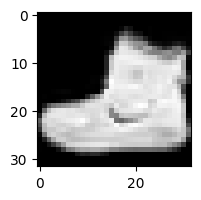

In [116]:
i = 0
img = dataset[i][0]

display_image(img)

In [117]:
batch = dataset[i][0].unsqueeze(0)
batch.shape

torch.Size([1, 1, 32, 32])

In [118]:
unet = UNet(in_channels=1, model_channels=64, out_channels=1, channel_mult=(1, 2, 4), attention_resolutions=[16], num_res_blocks=2)

In [119]:
unet(batch, torch.tensor([5])).shape

torch.Size([1, 1, 32, 32])

In [120]:
beta_start = 0.0001
beta_end = 0.02
T = 1000

diffusion = GaussianDiffusion(
    beta_start=beta_start,
    beta_end=beta_end,
    timesteps=T
)

In [121]:
noise = torch.randn_like(batch)
noise.shape

torch.Size([1, 1, 32, 32])

In [122]:
t = torch.tensor([999])
x_T = diffusion.q_sample(batch, t, noise)
x_T.shape

torch.Size([1, 1, 32, 32])

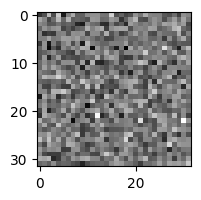

In [123]:
display_image(x_T[0])

In [126]:
# make model that returns predicted noise
def create_model(noise):
    def model(x, t):
        # return torch.randn((1, 1, 28, 28))
        # return torch.randn((1, 3, 32, 32))
        return noise
    
    return model

In [127]:
model = create_model(noise)
model

<function __main__.create_model.<locals>.model(x, t)>

In [128]:
sample = diffusion.sample(model, x_T)
sample

tensor([[[[ 1.0000,  1.0000, -1.0000,  ...,  1.0000, -1.0000, -0.8374],
          [-1.0000, -0.7459,  0.9967,  ...,  0.7765, -1.0000, -0.9819],
          [-0.9599,  0.3634,  0.6838,  ...,  0.6094, -0.5651,  1.0000],
          ...,
          [-0.7012,  1.0000,  1.0000,  ..., -0.1465,  0.9679,  0.7699],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9995,  0.3418, -0.9996],
          [ 0.5920,  0.6503,  1.0000,  ..., -1.0000, -1.0000, -1.0000]]]])

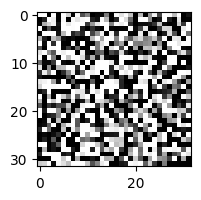

In [129]:
display_image(sample[0])

In [130]:
samples = []

x_t = x_T
x_0 = batch

for t in range(T - 1, 0, -1):
    t = torch.tensor([t])
    mean, var = diffusion.q_posterior_mean_var(x_t, x_0, t)
    z = torch.randn_like(x_t)
    x_t = mean + (var ** 0.5) * z
    samples.append(x_t) 

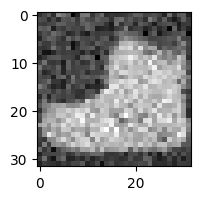

In [134]:
i = 950
display_image(samples[i][0])

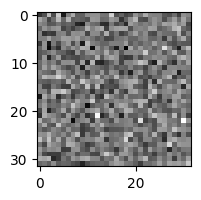

In [137]:
display_image(x_T[0])

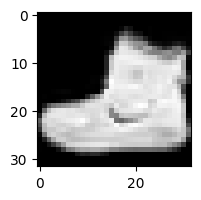

In [139]:
pred_x_0 = (x_T - ((1 - diffusion.alpha_bar[T - 1]) ** 0.5) * noise) / (diffusion.alpha_bar[T - 1] ** 0.5)
display_image(pred_x_0[0])